<a href="https://colab.research.google.com/github/fajarwr/Cell_Classification_KAIST/blob/master/Cell_Classification_KAIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import os
import sys
#sys.path.append('D:/Documents/Kuliah/DataScience/My Python Libraries')
#import confusion_matrix_pretty_print as cmpp
import pandas as pd
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
#import scikitplot as skplt
#from pandas_ml import ConfusionMatrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from pandas import ExcelWriter
from sklearn.model_selection import cross_val_predict

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#Define Feature Name
feature_name = []
feature_class = ['SA', 'CV', 'SI', 'PD', 'DM']
RI_treshold = [1.340,1.380,0.002]

for feature_idx in range(0,5):
    feature_name += ([feature_class[feature_idx] + x for x in [" {:0.3f}".format(x) for x in np.arange(RI_treshold[0],RI_treshold[1],RI_treshold[2])]])
label_name = ['NUM', 'CHAR']
#Number of feature
print('Number of feature = ', len(feature_name))

Number of feature =  100


In [4]:
cd

/root


In [5]:
cd /content

/content


In [6]:
ls

gdrive/  sample_data/


In [0]:
#Import Feature File
feature_dir = 'gdrive/My Drive/Cell_Classification_KAIST/002_Data'
feature_file_name = "features.xlsx"
label_file_name = "labels.xlsx"
os.chdir(feature_dir)
df_feature = pd.read_excel(feature_file_name,header = None)
df_feature.columns = feature_name
df_label = pd.read_excel(label_file_name,header = None)
df_label[1] = 'CD4'
df_label.loc[df_label[0]==2,(1)] = 'CD8'
df_label.loc[df_label[0]==3,(1)] = 'Memory_CD8'
df_label.loc[df_label[0]==4,(1)] = 'Naive_CD8'
df_label.columns = label_name

In [8]:
print('Print of feature data frame \n', df_feature.head())
print('Print of feature data frame \n', df_label.head())
print(len(df_label.iloc[:,1]=='CD4'))
print('\n Additional information')
print('SA : Specific surface area')
print('CV : Cellular volume')
print('SI : Sphericity')
print('PD : Protein density')
print('DM : Dry mass')
print('1.340, 1.342, ..., 1.378 : Refractive index')
print('NUM : number label')
print('CHAR : Character label')

Print of feature data frame 
      SA 1.340    SA 1.342    SA 1.344  ...   DM 1.374   DM 1.376   DM 1.378
0  336.942628  221.322113  198.905720  ...  25.111034  23.281200  21.027657
1  284.448915  197.500369  175.686598  ...  23.930401  22.835979  21.305340
2  392.447416  274.426477  242.141001  ...  29.064434  27.129330  24.657097
3  391.691157  262.933108  237.742285  ...  28.465515  25.823952  22.306225
4  354.327559  240.273398  210.543228  ...  18.060020  16.559818  14.598180

[5 rows x 100 columns]
Print of feature data frame 
    NUM CHAR
0    1  CD4
1    1  CD4
2    1  CD4
3    1  CD4
4    1  CD4
1231

 Additional information
SA : Specific surface area
CV : Cellular volume
SI : Sphericity
PD : Protein density
DM : Dry mass
1.340, 1.342, ..., 1.378 : Refractive index
NUM : number label
CHAR : Character label


In [0]:
#Pre-feature standardization
df_feature_standardized = df_feature.apply(zscore)

In [0]:
#Define feature & label variavel
X = df_feature_standardized[feature_name].values
y = df_label['NUM'].values

In [0]:
#Merged Data
df = df_feature
df['LABEL'] = df_label['NUM']
df['LYMPHOCYTES CELL'] = df_label['CHAR']

In [0]:
#Train test split
#A : binary classification of CD4 and CD8
#B : binary classification of Memory_CD8 and Naive_CD8
#C : multiclass classification of CD4, Memory_CD8 and Naive_CD8
random_state = 72
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X[np.logical_or(y ==1, y ==2),:], y[np.logical_or(y ==1, y ==2)], test_size=0.2, random_state=55, stratify=y[np.logical_or(y ==1, y ==2)])
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X[np.logical_or(y ==3, y ==4),:], y[np.logical_or(y ==3, y ==4)], test_size=0.2, random_state=random_state, stratify=y[np.logical_or(y ==3, y ==4)])
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X[np.logical_or(np.logical_or(y ==1, y ==3),y ==4),:], y[np.logical_or(np.logical_or(y ==1, y ==3),y ==4)], random_state=random_state, test_size=0.2, stratify=y[np.logical_or(np.logical_or(y ==1, y ==3),y ==4)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify=y)

<Figure size 432x288 with 0 Axes>

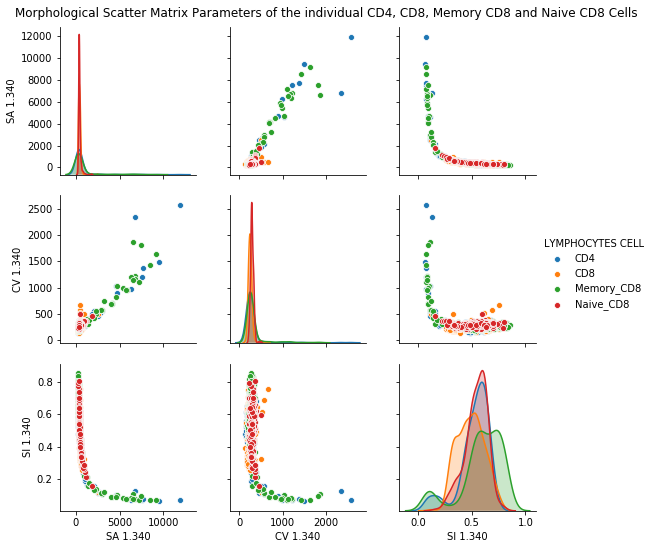

<Figure size 432x288 with 0 Axes>

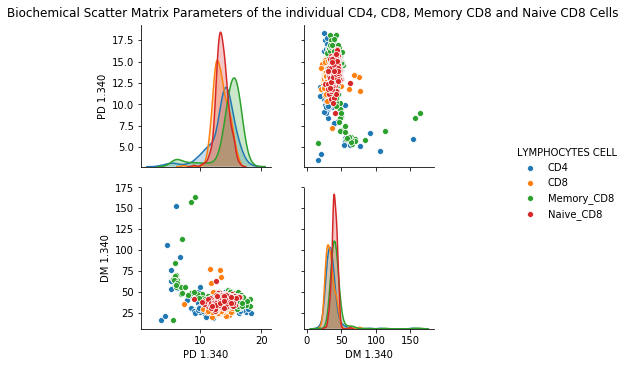

In [0]:
##Explolatory data analysis##

#Plot the xample of selected feature
selected_features = ['SA 1.340', 'CV 1.340', 'SI 1.340']
#Plot Scatter matrix
plt.figure()
sns.pairplot(df, vars=selected_features, hue='LYMPHOCYTES CELL')
plt.suptitle('Morphological Scatter Matrix Parameters of the individual CD4, CD8, Memory CD8 and Naive CD8 Cells',y=1.01)
plt.show()

#Plot the xample of selected feature
selected_features = ['PD 1.340', 'DM 1.340']
#Plot Scatter matrix
plt.figure()
sns.pairplot(df, vars=selected_features, hue='LYMPHOCYTES CELL')
plt.suptitle('Biochemical Scatter Matrix Parameters of the individual CD4, CD8, Memory CD8 and Naive CD8 Cells',y=1.01)
plt.show()

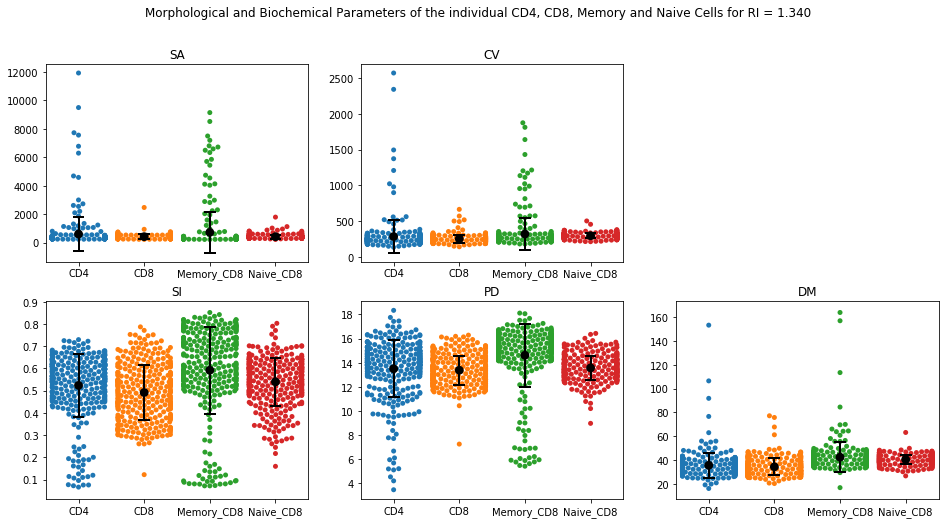

In [0]:
##Explolatory data analysis cont.##
#Plot the xample of selected feature
selected_features = ['SA 1.340', 'CV 1.340', 'SI 1.340', 'PD 1.340', 'DM 1.340']
#Plot scattered data
plt.figure(figsize=(16,8))
for plt_idx in range(0,5):    
    if plt_idx < 2:
        plt.subplot(int('23'+str(plt_idx+1)))
    if plt_idx >= 2:
        plt.subplot(int('23'+str(plt_idx+2)))
    sns.swarmplot(x=df_label['CHAR'].values, y=df_feature[selected_features[plt_idx]].values, zorder=1)
    sns.pointplot(x=df_label['CHAR'].values, y=df_feature[selected_features[plt_idx]].values, ci="sd", estimator=np.mean, join = False, capsize = 0.15, color = 'black', zorder=2, errwidth =2)
    plt.title(feature_class[plt_idx])
plt.suptitle('Morphological and Biochemical Parameters of the individual CD4, CD8, Memory and Naive Cells for RI = 1.340')
plt.show()

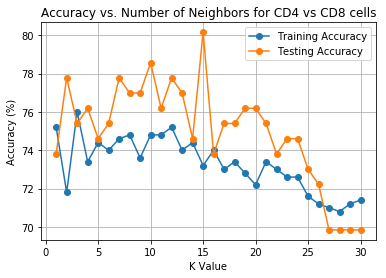

In [0]:
#A case
#Training for Each k (Choosing the best k)
k_range = range(1,31)
k_train_accuracy = []
loo = LeaveOneOut()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    k_train_accuracy.append(np.mean(cross_val_score(knn, X_train_A, y_train_A, cv=loo))*100)

#Testing for Each k
k_test_accuracy = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_A,y_train_A)
    k_test_accuracy.append(knn.score(X_test_A,y_test_A)*100)

#Ploting accuracy each k value
#The smaller k value, the higher complexity
#The best k value indicated with high accuracy and less complexity
plt.figure
plt.plot(k_range,k_train_accuracy, marker = 'o')
plt.plot(k_range,k_test_accuracy, marker = 'o')
plt.title('Accuracy vs. Number of Neighbors for CD4 vs CD8 cells')
plt.xlabel('K Value')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc = 'upper right')
plt.show()

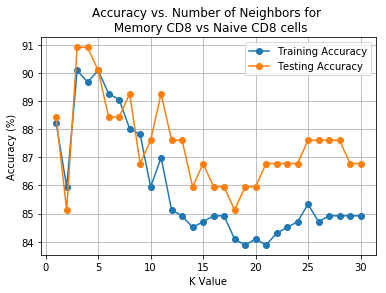

In [0]:
#B case
#Training for Each k (Choosing the best k)
k_range = range(1,31)
k_train_accuracy = []
loo = LeaveOneOut()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    k_train_accuracy.append(np.mean(cross_val_score(knn, X_train_B, y_train_B, cv=loo))*100)

#Testing for Each k
k_test_accuracy = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_B,y_train_B)
    k_test_accuracy.append(knn.score(X_test_B,y_test_B)*100)

#Ploting accuracy each k value
#The smaller k value, the higher complexity
#The best k value indicated with high accuracy and less complexity
plt.figure
plt.plot(k_range,k_train_accuracy, marker = 'o')
plt.plot(k_range,k_test_accuracy, marker = 'o')
plt.title('Accuracy vs. Number of Neighbors for \n Memory CD8 vs Naive CD8 cells')
plt.xlabel('K Value')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc = 'upper right')
plt.show()

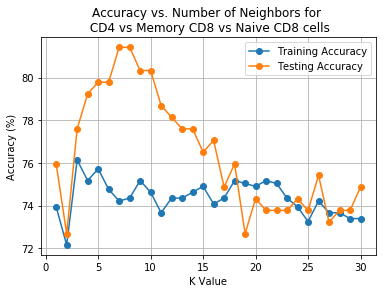

In [0]:
#C case
#Training for Each k (Choosing the best k)
k_range = range(1,31)
k_train_accuracy = []
loo = LeaveOneOut()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    k_train_accuracy.append(np.mean(cross_val_score(knn, X_train_C, y_train_C, cv=loo))*100)

#Testing for Each k
k_test_accuracy = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_C,y_train_C)
    k_test_accuracy.append(knn.score(X_test_C,y_test_C)*100)

#Ploting accuracy each k value
#The smaller k value, the higher complexity
#The best k value indicated with high accuracy and less complexity
plt.figure
plt.plot(k_range,k_train_accuracy, marker = 'o')
plt.plot(k_range,k_test_accuracy, marker = 'o')
plt.title('Accuracy vs. Number of Neighbors for \n CD4 vs Memory CD8 vs Naive CD8 cells')
plt.xlabel('K Value')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc = 'upper right')
plt.show()

In [0]:
#Feature Selection
#Case A
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
loo = LeaveOneOut()
sfs_A = SFS(estimator=knn, k_features=(1,100), scoring='accuracy', cv=loo)
sfs_A.fit(X_train_A, y_train_A,custom_feature_names=feature_name)
print('best combination (ACC: %.3f): %s\n' % (sfs_A.k_score_, sfs_A.k_feature_names_))
df_sfs_A = pd.DataFrame.from_dict(sfs_A.get_metric_dict()).T

best combination (ACC: 0.836): ('SA 1.340', 'SA 1.342', 'SA 1.344', 'SA 1.346', 'SI 1.342', 'SI 1.344', 'SI 1.370', 'SI 1.372', 'SI 1.374', 'PD 1.346', 'PD 1.354', 'PD 1.360', 'PD 1.362', 'PD 1.364', 'PD 1.378')



In [0]:
#Case B
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
loo = LeaveOneOut()
sfs_B = SFS(estimator=knn, k_features=(1,100), scoring='accuracy', cv=loo)
sfs_B.fit(X_train_B, y_train_B,custom_feature_names=feature_name)
print('best combination (ACC: %.3f): %s\n' % (sfs_B.k_score_, sfs_B.k_feature_names_))
df_sfs_B = pd.DataFrame.from_dict(sfs_B.get_metric_dict()).T 

best combination (ACC: 0.959): ('SA 1.340', 'SA 1.342', 'SA 1.344', 'SA 1.346', 'SA 1.348', 'CV 1.342', 'SI 1.340', 'SI 1.342', 'SI 1.344', 'SI 1.348', 'SI 1.362', 'SI 1.364', 'SI 1.374', 'SI 1.376', 'PD 1.340', 'PD 1.364', 'PD 1.372', 'PD 1.374', 'PD 1.376')



In [0]:
#Case C
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
loo = LeaveOneOut()
sfs_C = SFS(estimator=knn, k_features=(1,100), scoring='accuracy', cv=loo)
sfs_C.fit(X_train_C, y_train_C,custom_feature_names=feature_name)
print('best combination (ACC: %.3f): %s\n' % (sfs_C.k_score_, sfs_C.k_feature_names_))
df_sfs_C = pd.DataFrame.from_dict(sfs_C.get_metric_dict()).T

best combination (ACC: 0.850): ('CV 1.376', 'SI 1.340', 'SI 1.374', 'PD 1.340', 'PD 1.376', 'PD 1.378', 'DM 1.368')



In [0]:
pwd

'/content/gdrive/My Drive/Cell_Classification_KAIST/002_Data'

In [0]:
#Save and load

df_sfs_A.to_excel('df_sfs_A.xlsx')
df_sfs_B.to_excel('df_sfs_B.xlsx')
df_sfs_C.to_excel('df_sfs_C.xlsx')

df_sfs_A = pd.read_excel('df_sfs_A.xlsx')
df_sfs_B = pd.read_excel('df_sfs_B.xlsx')
df_sfs_C = pd.read_excel('df_sfs_C.xlsx')

<function matplotlib.pyplot.show>

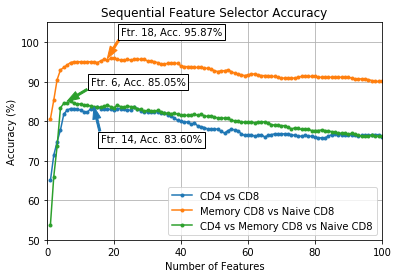

In [0]:
#Show feature selection result
plt.figure
p = plt.plot(np.arange(1,101),df_sfs_A['avg_score'].values*100, np.arange(1,101),df_sfs_B['avg_score'].values*100, np.arange(1,101),df_sfs_C['avg_score'].values*100, marker = 'o', markersize=3)
plt.axis([0, 100, 50, 105])
plt.title('Sequential Feature Selector Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['CD4 vs CD8', 'Memory CD8 vs Naive CD8', 'CD4 vs Memory CD8 vs Naive CD8'], loc = 'lower right')
xy = (df_sfs_A.index[df_sfs_A['avg_score']==np.max(df_sfs_A['avg_score'])][0], np.max(df_sfs_A['avg_score'])*100)
xytext = (df_sfs_A.index[df_sfs_A['avg_score']==np.max(df_sfs_A['avg_score'])][0]+2, np.max(df_sfs_A['avg_score'])*100-9)
text = 'Ftr. %d, Acc. %.2f%%' % (df_sfs_A.index[df_sfs_A['avg_score']==np.max(df_sfs_A['avg_score'])][0], np.max(df_sfs_A['avg_score'])*100)
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[0].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
xy = (df_sfs_B.index[df_sfs_B['avg_score']==np.max(df_sfs_B['avg_score'])][0], np.max(df_sfs_B['avg_score'])*100)
xytext = (df_sfs_B.index[df_sfs_B['avg_score']==np.max(df_sfs_B['avg_score'])][0]+4, np.max(df_sfs_B['avg_score'])*100+6)
text = 'Ftr. %d, Acc. %.2f%%' % (df_sfs_B.index[df_sfs_B['avg_score']==np.max(df_sfs_B['avg_score'])][0], np.max(df_sfs_B['avg_score'])*100)
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[1].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
xy = (df_sfs_C.index[df_sfs_C['avg_score']==np.max(df_sfs_C['avg_score'])][0], np.max(df_sfs_C['avg_score'])*100)
xytext = (df_sfs_C.index[df_sfs_C['avg_score']==np.max(df_sfs_C['avg_score'])][0]+7, np.max(df_sfs_C['avg_score'])*100+4)
text = 'Ftr. %d, Acc. %.2f%%' % (df_sfs_C.index[df_sfs_C['avg_score']==np.max(df_sfs_C['avg_score'])][0], np.max(df_sfs_C['avg_score'])*100)
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[2].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
plt.show

In [0]:
#Define feature & label variavel from feature selection
selected_feature_A = ['SA 1.340', 'SA 1.342', 'SA 1.344', 'SA 1.346', 'SI 1.342', 'SI 1.344', 'SI 1.370', 'SI 1.372', 'SI 1.374', 'PD 1.346', 'PD 1.354', 'PD 1.360', 'PD 1.362', 'PD 1.364', 'PD 1.378']
selected_feature_B = ['SA 1.340', 'SA 1.342', 'SA 1.344', 'SA 1.346', 'SA 1.348', 'CV 1.342', 'SI 1.340', 'SI 1.342', 'SI 1.344', 'SI 1.348', 'SI 1.362', 'SI 1.364', 'SI 1.374', 'SI 1.376', 'PD 1.340', 'PD 1.364', 'PD 1.372', 'PD 1.374', 'PD 1.376']
selected_feature_C = ['CV 1.376', 'SI 1.340', 'SI 1.374', 'PD 1.340', 'PD 1.376', 'PD 1.378', 'DM 1.368']
X = df_feature_standardized[selected_feature_C].values
y = df_label['NUM'].values

In [0]:
#Data Merged
df = df_feature
df['LABEL'] = df_label['NUM']
df['LYMPHOCYTES CELL'] = df_label['CHAR']

In [0]:
#Train test split
#A : binary classification of CD4 and CD8
#B : binary classification of Memory_CD8 and Naive_CD8
#C : multiclass classification of CD4, Memory_CD8 and Naive_CD8
random_state = 72
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X[np.logical_or(y ==1, y ==2),:], y[np.logical_or(y ==1, y ==2)], test_size=0.2, random_state=55, stratify=y[np.logical_or(y ==1, y ==2)])
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X[np.logical_or(y ==3, y ==4),:], y[np.logical_or(y ==3, y ==4)], test_size=0.2, random_state=random_state, stratify=y[np.logical_or(y ==3, y ==4)])
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X[np.logical_or(np.logical_or(y ==1, y ==3),y ==4),:], y[np.logical_or(np.logical_or(y ==1, y ==3),y ==4)], random_state=random_state, test_size=0.2, stratify=y[np.logical_or(np.logical_or(y ==1, y ==3),y ==4)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify=y)

Case A, Confusion Matrix Train :
[[184  61]
 [ 68 187]]
Case A, Confusion Matrix Test :
[[51 11]
 [13 51]]
Train acc. 74.200000
Test acc. 80.952381


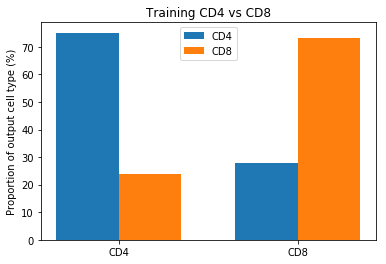

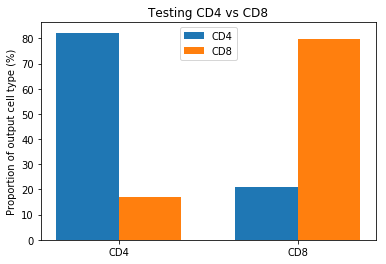

In [0]:
#Show the result
#Dont forget to choose selected feature
#A Case
loo = LeaveOneOut()
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
y_pred = cross_val_predict(knn, X_train_A, y_train_A, cv=loo)
cm_train = confusion_matrix(y_train_A,  y_pred)
print('Case A, Confusion Matrix Train :')
print(cm_train)
knn.fit(X_train_A,y_train_A)
cm_test = confusion_matrix(y_test_A,  knn.predict(X_test_A))
print('Case A, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(knn, X_train_A, y_train_A, cv=loo))*100))
print('Test acc. %f' %(knn.score(X_test_A,y_test_A)*100))

N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
CD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs CD8')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
CD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs CD8')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

Case B, Confusion Matrix Train :
[[215  22]
 [ 11 236]]
Case B, Confusion Matrix Test :
[[54  5]
 [ 3 59]]
Train acc. 93.181818
Test acc. 93.388430


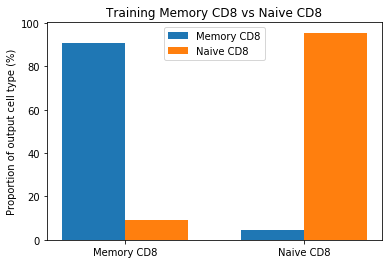

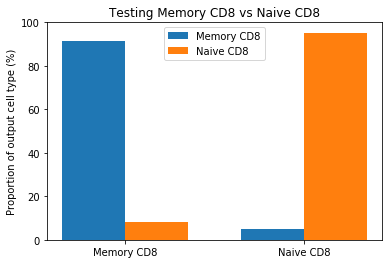

In [0]:
#Dont forget to choose selected feature
#B Case
loo = LeaveOneOut()
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
y_pred = cross_val_predict(knn, X_train_B, y_train_B, cv=loo)
cm_train = confusion_matrix(y_train_B,  y_pred)
print('Case B, Confusion Matrix Train :')
print(cm_train)
knn.fit(X_train_B,y_train_B)
cm_test = confusion_matrix(y_test_B,  knn.predict(X_test_B))
print('Case B, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(knn, X_train_B, y_train_B, cv=loo))*100))
print('Test acc. %f' %(knn.score(X_test_B,y_test_B)*100))

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
NCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training Memory CD8 vs Naive CD8')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
NCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing Memory CD8 vs Naive CD8')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

Case C, Confusion Matrix Train :
[[198  33  14]
 [ 25 197  15]
 [ 13   9 225]]
Case C, Confusion Matrix Test :
[[51  9  2]
 [ 9 45  5]
 [ 5  1 56]]
Train acc. 85.048011
Test acc. 83.060109


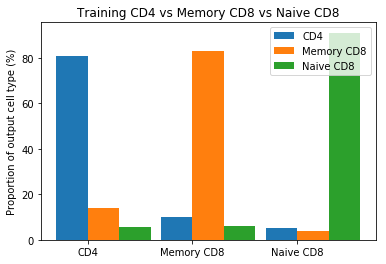

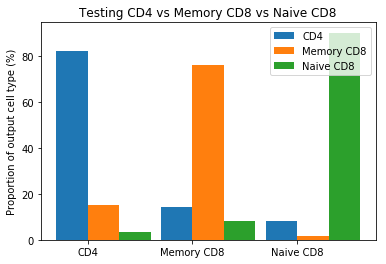

In [0]:
#Dont forget to choose selected feature
#C Case
loo = LeaveOneOut()
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
y_pred = cross_val_predict(knn, X_train_C, y_train_C, cv=loo)
cm_train = confusion_matrix(y_train_C,  y_pred)
print('Case C, Confusion Matrix Train :')
print(cm_train)
knn.fit(X_train_C,y_train_C)
cm_test = confusion_matrix(y_test_C,  knn.predict(X_test_C))
print('Case C, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(knn, X_train_C, y_train_C, cv=loo))*100))
print('Test acc. %f' %(knn.score(X_test_C,y_test_C)*100))


N = 3
ind = np.arange(N)
width = 0.3
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
MCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
NCD8_out = cm_train[:,2]/np.sum(cm_train[2,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,MCD8_out, width, label='Memory CD8')
plt.bar(ind+2*width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs Memory CD8 vs Naive CD8')
plt.xticks(ind + width / 2, ('CD4', 'Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 3
ind = np.arange(N)
width = 0.3
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
MCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
NCD8_out = cm_test[:,2]/np.sum(cm_test[2,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,MCD8_out, width, label='Memory CD8')
plt.bar(ind+2*width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs Memory CD8 vs Naive CD8')
plt.xticks(ind + width / 2, ('CD4', 'Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()